In [0]:
#En nuestro caso, vamos a trabajar con datos sobre la Liga Santander. Los datos son suministrados por StatsBomb y están disponibles como base de datos abierta en la página https://fbref.com. La propia página da la opción de descargar los datos que nos interesen en formato csv, que es lo que se ha hecho para este ejercicio. 
#En función de cada tipo de modelo, se utilizarán unos datos u otros. El procesado, preparación y descripción de los mismos va a depender del tipo de modelo, así que las explicaciones de estos apartados se incluyen en los correspondientes a cada uno de los modelos. 

In [0]:
#El objetivo de este primer apartado es crear un modelo de clasificación binaria, que prediga la clasificación para puestos europeos en Primera División en función de métricas relacionadas con los tiros obtenidas en la temporada anterior. Es decir, desarrollaremos un modelo que prediga si se van a conseguir puestos europeos esta temporada con las estadísticas de disparos que se están obteniendo, basándose en resultados de la temporada anterior. 

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import warnings
warnings.filterwarnings("ignore")

#Para comenzar, cargamos los datos que nos interesan. En este caso son dos tablas:
#     -La tabla General1819 contiene información general sobre los equipos, como son los puntos, la posición, los goles, etc de la temporada pasada.              Esta tabla nos interesa solamente porque incluye la posición que ocupa cada equipo.
#     -La tabla Tiros1819 es con la que vamos a trabajar principalmente, en cuanto incluye información sobre distintas métricas relacionadas con los tiros, #      como se verá a continuación, también referidos a la temporada pasada. 
df1 = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/General1819.csv')
df2 = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/Tiros1819.csv')

#Una vez que hemos cargado ambos conjuntos de datos, los unimos, para incluir la posición de los equipos en la información que tenemos. 
df3 = df1.join(df2,['Squad'],how='inner')

#Añadimos una nueva columna, que nos servirá para nuestra clasificación binaria, y nos dice si el equipo está en puestos europeos (posiciones 1ª y 2ª) o no.

df3 = df3.withColumn(
    'TARGET_Eu',when((col('Rk') <= 7), 1)\
    .otherwise(0))
 #Limpiamos el dataframe para quedarnos únicamente con las columnas que nos interesan.
df3 = df3.drop('MP','W','D','L','GF','xG','GA','GDiff','Pts','xGA','xGDiff','xGDiff/90','Last 5','Attendance','Top Team Scorer','Goalkeeper','Notes','# Pl','Gls','PK','PKatt','Rk')

display(df3)
#Ya tenemos listo el conjunto de datos para trabajar con él. Las categorías a las que se refiere cada columna son las siguientes:
  #Sh: Disparos
  #SoT: Disparos a puerta
  #FK: Tiros libres.
  #SoT%: Porcentaje de disparos a puerta sobre el total de disparos.
  #Sh/90: Disparos por cada 90 minutos.
  #SoT/90: Disparos a puerta por cada 90 minutos.
  #G/Sh: Goles marcados por cada disparo.
  #G/SoT: Goles marcados por cada disparo a puerta
  #npxG: Goles esperados sin contar los penaltis.
  #npxG: Goles esperados sin contar los penaltis por cada disparo (mide la calidad media de las ocasiones del equipo)
  #G-xG: diferencia entre los goles marcados realmente y los goles esperados.
  #np:G-xG: misma métrica que la anterior pero sin contar penaltis
  #TARGET_Eu: clasificación binaria, donde 0 significa no estar en puestos europeos y 1 sí estarlo.

Squad,Sh,SoT,FK,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,npxG,npxG/Sh,G-xG,np:G-xG,TARGET_Eu
Alavés,419,118,15,28.2,11.03,3.11,0.09,0.31,35.4,0.09,1.3,1.6,0
Athletic Bilbao,368,133,6,36.1,9.68,3.5,0.09,0.24,33.6,0.1,-2.1,-1.6,0
Atlético Madrid,439,160,21,36.4,11.55,4.21,0.11,0.31,41.3,0.1,7.6,7.7,1
Barcelona,552,243,50,44.0,14.53,6.39,0.14,0.33,67.3,0.13,13.9,12.7,1
Betis,440,154,31,35.0,11.58,4.05,0.09,0.25,42.4,0.1,-4.7,-4.4,0
Celta Vigo,438,157,21,35.8,11.53,4.13,0.1,0.29,39.0,0.09,7.9,6.0,0
Eibar,519,154,19,29.7,13.66,4.05,0.08,0.25,44.7,0.09,-4.6,-5.7,0
Espanyol,464,153,25,33.0,12.21,4.03,0.08,0.25,45.6,0.1,-5.6,-6.6,1
Getafe,385,123,12,31.9,10.13,3.24,0.11,0.33,39.8,0.11,2.7,1.2,1
Girona,394,140,18,35.5,10.37,3.68,0.08,0.22,35.2,0.09,-2.4,-4.2,0


In [0]:
#Comprobamos que no hay ningún tipo de valor extraño obteniento la descripción estadística del dataframe
dfdescribe = df3.describe().toPandas().transpose()
dfdescribe

,0,1,2,3,4
summary,count,mean,stddev,min,max
Squad,20,None,None,Alavés,Villarreal
Sh,20,451.35,55.68357501378471,368,579
SoT,20,152.45,28.748409566993075,118,243
FK,20,19.75,9.623846479066028,6,50
SoT%,20,33.66,3.374735857109881,28.2,44.0
Sh/90,20,11.878500000000004,1.466493400850083,9.68,15.24
SoT/90,20,4.0115,0.7555010536758126,3.11,6.39
G/Sh,20,0.09400000000000003,0.016982963599783726,0.07,0.14
G/SoT,20,0.274,0.038580060298444054,0.21,0.34


In [0]:
#Pasamos ahora a obtener la correlación estadística de todas las variables que tenemos con nuestra variable objetivo. Para ello
#utilizamos la función corr, que nos va a dar una medición cuantitativa de esta correlación. Cuanto más cerca esté de 1, mayor relación hay entre variables.
import six
for i in df3.columns:
  if not( isinstance(df3.select(i).take(1)[0][0], six.string_types)):
    print( i, "Su correlación con TARGET_Eu es:",    df3.stat.corr('TARGET_Eu', i))
    
#Podemos observar que la variable que más correlaciona con nuestra variable objetivo es npxG, es decir, los goles esperados sin contar penaltis.

Sh Su correlación con TARGET_Eu es: 0.46268622097275747
SoT Su correlación con TARGET_Eu es: 0.515715813165015
FK Su correlación con TARGET_Eu es: 0.2095415184891176
SoT% Su correlación con TARGET_Eu es: 0.3403681921439709
Sh/90 Su correlación con TARGET_Eu es: 0.4620749275387281
SoT/90 Su correlación con TARGET_Eu es: 0.516689014022762
G/Sh Su correlación con TARGET_Eu es: 0.519299464572717
G/SoT Su correlación con TARGET_Eu es: 0.4516163055166298
npxG Su correlación con TARGET_Eu es: 0.6799521201156105
npxG/Sh Su correlación con TARGET_Eu es: 0.5801690933963233
G-xG Su correlación con TARGET_Eu es: 0.22753372906183048
np:G-xG Su correlación con TARGET_Eu es: 0.17681310106614398
TARGET_Eu Su correlación con TARGET_Eu es: 1.0

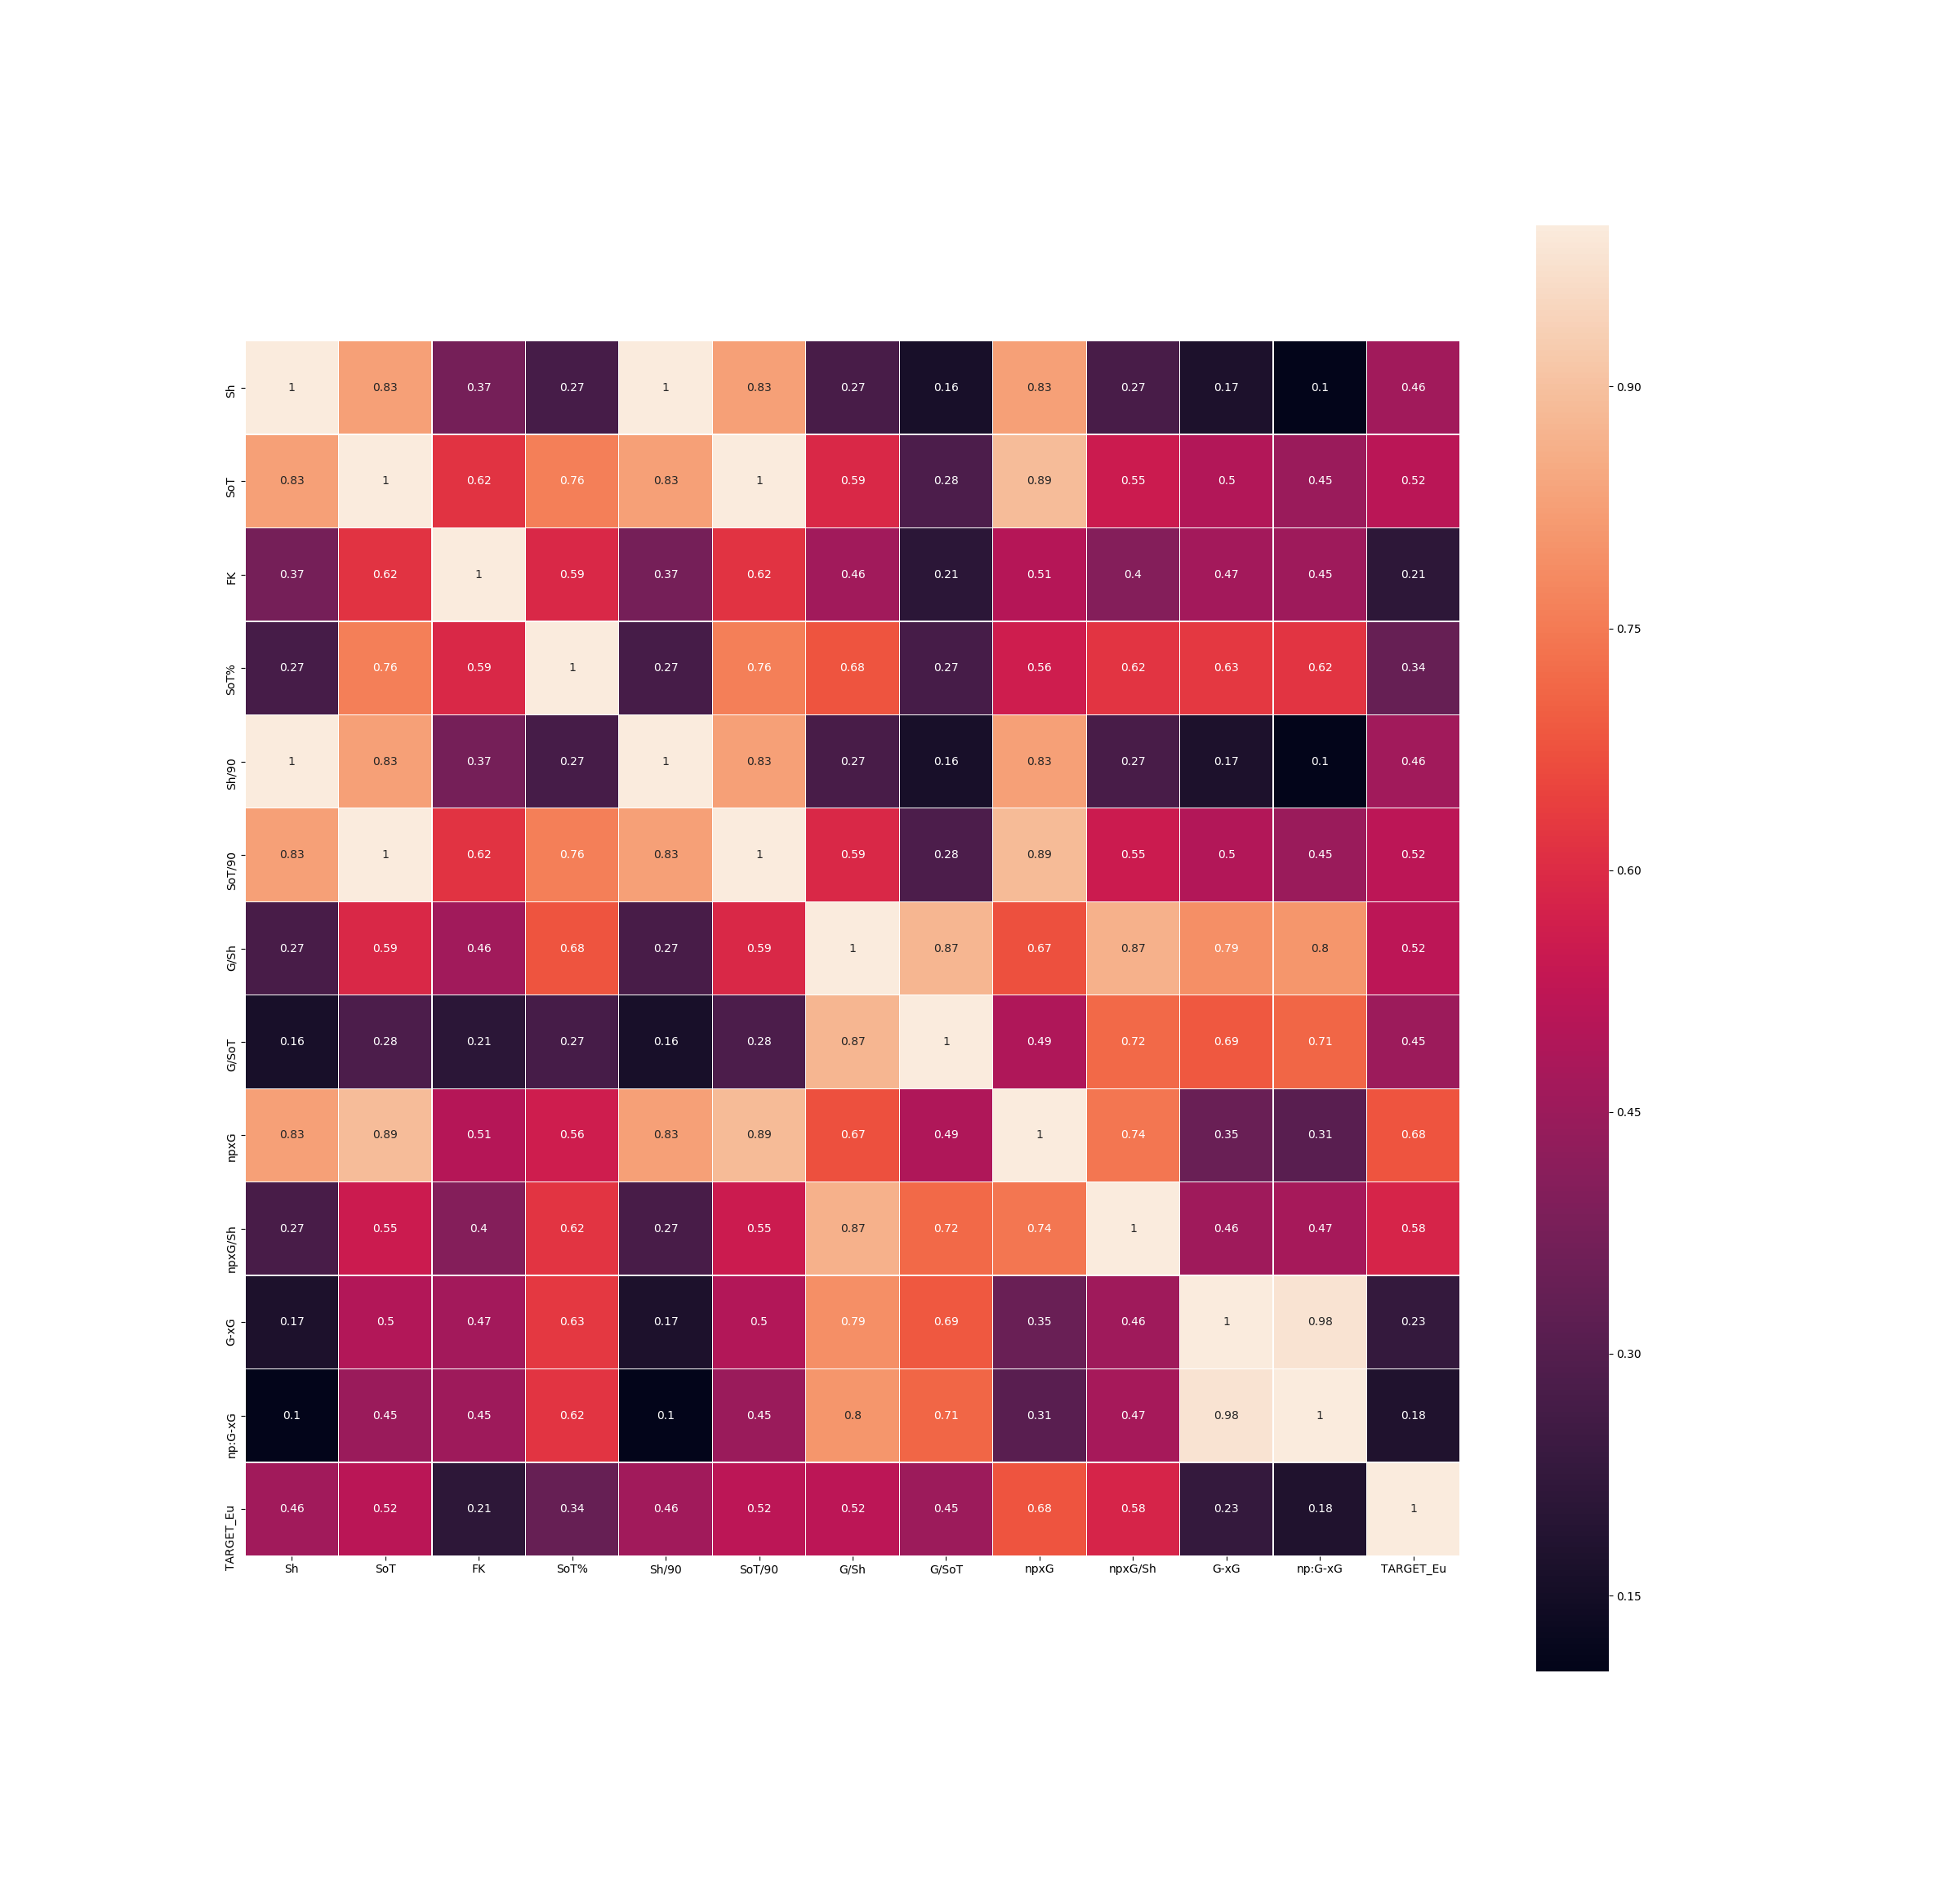

In [0]:
#De hecho, podemos echar un ojo a la representación gráfica en una matriz de correlación. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(24,23))
sns.heatmap(df3.select([c for c in df3]).toPandas().corr(),linewidths=0.2,vmax=1.0, square=True, linecolor="white",annot=True)
display(plt.show())
plt.gcf().clear()
plt.clear()
#En este caso, cuanto más claro es el color de la celda, más correlación estadística hay entre variables.

In [0]:
#Una vez que ya tenemos el dataframe listo y que observamos que hay ciertas variables que pueden tener suficiente relevancia estadística, pasamos al entrenamiento de nuestro modelo. Para ello, vamos a utilizar el dataframe que ya tenemos. Una vez entrenado, aplicaremos nuestro modelo a los datos que tenemos de esta temporada para obtener nuestra predicción.

#Para empezar, vamos a preparar los datos para integrarlos en el modelo y nuestra pipeline para ejecutar todas las etapas.

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#Creamos el vector en el que se van a incluir los datos de nuestra pipeline
stages =[]
#Operamos sobre la columna referente al nombre de los equipos, que es una cadena de texto, para etiquetarla e indexarla.
ColumnaTexto = ['Squad']
for Col in ColumnaTexto:
  stringIndexer = StringIndexer(inputCol=Col, outputCol=Col + "Index")
  encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[Col + "classVec"])
  stages += [stringIndexer, encoder]
  
labelstring = StringIndexer(inputCol="TARGET_Eu",outputCol="label")
squadstring = StringIndexer(inputCol='Squad',outputCol='Squad_Index')
stages += [labelstring, squadstring]

#Eliminamos la columna Squad, nos quedamos solo con las columnas con valores numéricos
features = ['Squad_Index','Sh','SoT','FK','SoT%','Sh/90','SoT/90','G/Sh','G/SoT','npxG','npxG/Sh','G-xG','np:G-xG','TARGET_Eu']

#Definimos una última etapa de la pipeline
vectorAssembler = VectorAssembler (inputCols = features, outputCol = 'features')
stages += [vectorAssembler]

#Ejecutamos las etapas que hemos incluido en la pipeline. 

from pyspark.ml import Pipeline
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(df3)
dffinal=pipelineModel.transform(df3)

In [0]:
#Vamos a dejar preparados los datos de esta temporada para poder aplicarle el modelo que vamos a entrenar. 
df4 = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/General1920.csv')
df5 = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/Tiros1920.csv')

df6 = df4.join(df5,['Squad'],how='inner')

df6 = df6.withColumn(
    'TARGET_Eu',
    when((col("Rk") <= 7), 1)\
    .otherwise(0)
)

df6 = df6.drop('MP','W','D','L','GF','xG','GA','GDiff','Pts','xGA','xGDiff','xGDiff/90','Last 5','Attendance','Top Team Scorer','Goalkeeper','Notes','# Pl','Gls','PK','PKatt','Rk')

#Ejecutamos la pipeline para dejarlos preparados:
pipelineModel = pipeline.fit(df6)
dffinal2=pipelineModel.transform(df6)

In [0]:
#Una vez preparados los datos para incluirlos en nuestro modelo, procedemos a entrenarlo. Vamos a utilizar en este caso un modelo de regresión logística.
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=15, regParam=0.3, elasticNetParam=0,family="binomial")
lrModel=(lr.fit(dffinal))

In [0]:
#Una vez entrenado, lo aplicamos sobre los datos de esta temporada utilizando la función transform y nos quedamos con las columnas que nos interesan. En este caso, como vimos que los goles esperados sin contar penaltis era la columna que más correlación estadística tenía, es la que hemos seleccionado. 
predict = lrModel.transform(dffinal2)
display(predict.select("Squad","npxG","label","prediction"))

#Como podemos observar, nuestro modelo falla porque no incluye la condición de que tiene que haber 7 equipos en puestos europeos. Lo que nuestro modelo nos está diciendo es simplemente que equipos están consiguiendo unos valores de las variables relacionados con los que la temporada anterior llevaron a esos equipos a puestos europeos. Los fallos del modelo, aparte del mencionado, lógicamente también vienen de que el rendimiento de un equipo no se puede valorar únicamente con las estadísticas referentes a los disparos. 

Squad,npxG,label,prediction
Real Madrid,38.0,1.0,1.0
Barcelona,36.5,1.0,1.0
Getafe,21.8,1.0,0.0
Atlético Madrid,28.5,1.0,1.0
Sevilla,27.1,1.0,1.0
Real Sociedad,28.7,1.0,1.0
Valencia,22.4,1.0,0.0
Villarreal,32.5,0.0,0.0
Athletic Bilbao,19.3,0.0,0.0
Granada,20.0,0.0,0.0


In [0]:
#Para evaluar nuestro modelo, vamos a utilizar la métrica accuracy, que nos va a medir el número de predicciones correctas sobre el número total de predicciones.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
score = predict.select("prediction","label")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
rateLR = evaluator.evaluate(score)*100
print(rateLR)

#Como podemos ver, se obtiene un valor de accuracy bastante bueno.

90.0

In [0]:
#En este caso vamos a utilizar la herramienta de tuning que nos ofrece Spark llamada TrainValidationSplit. TrainValidationSplit evalúa cada combinación de parámetros una vez, por lo que exige menos memoria y tiempo, aunque los resultados sean menos exactos, especialmente trabajando con datasets tan pequeños como el de nuestro caso. 

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit



#Usamos ParamGridBuilder para definir la muestra de parámetros que queremos optimizar. 
#TrainValidationSplit probará todas las combinaciones de valores de estos parámetros y utilizará el evaluador para determinar el mejor modelo.

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

#En este caso el estimador es simplemente la regresión logística que hemos realizado más arriba.

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           #El trainRatio nos dice que un 80% de los datos se usarán para entrenar y el 20% restante como test. 
                           trainRatio=0.8)


#Aplicamos el modelo de TrainValidationSplit, y elegimos el mejor set de parámetros,que quedan guardados como model.
model = tvs.fit(dffinal2)

#Realizamos de nuevo las predicciones sobre los datos, aplicando la combinación de parámetros ya optimizada.
model.transform(dffinal2)\
    .select("Squad","features", "label", "prediction")\
    .show(20)

#Podemos ver ahora que hemos conseguido una accuracy del 100%, por lo que se ve la importancia que tiene encontrar los parámetros óptimos a la hora de aplicar cualquier algoritmo de Machine Learning. 

/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
+---------------+--------------------+-----+----------+
 Squad| features|label|prediction|
+---------------+--------------------+-----+----------+
 Alavés|[4.0,189.0,65.0,6...| 0.0| 0.0|
Athletic Bilbao|[18.0,243.0,79.0,...| 0.0| 0.0|
Atlético Madrid|[2.0,271.0,82.0,6...| 1.0| 1.0|
 Barcelona|[17.0,295.0,134.0...| 1.0| 1.0|
 Betis|[7.0,274.0,90.0,1...| 0.0| 0.0|
 Celta Vigo|[10.0,239.0,81.0,...| 0.0| 0.0|
 Eibar|[15.0,245.0,73.0,...| 0.0| 0.0|
 Espanyol|[1.0,262.0,75.0,3...| 0.0| 0.0|
 Getafe|[14.0,233.0,75.0,...| 1.0| 1.0|
 Granada|[19.0,227.0,59.0,...| 0.0| 0.0|
 Leganés|[5.0,248.0,95.0,1...| 0.0| 0.0|
 Levante|[16.0,260.0,85.0,...| 0.0| 0.0|
 Mallorca|[6.0,235.0,62.0,1...| 0.0| 0.0|
 Osasuna|[9.0,298.0,93.0,1...| 0.0| 0.0|
 Real Madrid|[12.0,368.0,140.0...| 1.0| 1.0|
 Real Sociedad|[3.0,255.0,87.0,6...| 1.0| 1.0|
 Sevilla|[0.0,296.0,96.0,8...| 1.0| 1.0|
 Valencia|[11.0,208.0,75.0,...| 1.0| 1.0|
 Valladolid|[8.0,210.0,69.0,1...| 0.0| 0.0|
 Villarreal|[13.0,317.0,100.0...| 0.0| 0.0|
+---------------+--------------------+-----+----------+

In [0]:
#El objetivo de este segundo apartado es crear un modelo de regresión lineal, que prediga la evolución de la métrica de xGA (goles esperados en contra) para los partidos que quedan de la temporada 19/20 del Athletic de Bilbao, teniendo en cuenta los resultados de esta variable en las 23 jornadas que se llevan disputadas. 
from pyspark.sql import *
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings("ignore")

#Para comenzar, cargamos los datos que nos interesan. En este caso va a ser solamente una tabla, llamada ATH.csv, que incluye información relevante sobre cada partido que ha disputado el equipo.

df1 = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/ATH.csv')

#El formato en el que nos viene la jornada nos va a dar problemas, así que nos quedamos únicamente con el valor numérico de la misma.


split_col = split(df1['Round'], ' ')
df = df1.withColumn('Jornada', split_col.getItem(1))
df = df.withColumn('Jornada', df.Jornada.cast('float'))
 #Limpiamos el dataframe para quedarnos únicamente con las columnas que nos interesan.
df = df.drop('Round','Day','Date','Time','Venue','Result','GF','GA','Opponent','xG','Attendance','Captain','Formation','Referee','Match Report','Notes')

#Ya tenemos listo el conjunto de datos para trabajar con él.

In [0]:
#Para crear el modelo, definimos como variable label los goles esperados en contra xGA, y como variable predictora la Jornada. 
#Mediante VectorAssembler preparamos el vector:

from pyspark.ml.feature import VectorAssembler
t = VectorAssembler(inputCols=['Jornada'], outputCol = 'features')
dfcompleto=t.transform(df)

#Vamos a preparar ahora el dataframe para utilizarlo para entrenar nuestro modelo. Como dataframe de entrenamiento vamos a utilizar las jornadas que se llevan disputadas (de la 1 a la 23), y como dataframe para el test utilizaremos las jornadas restantes.

training=sqlContext.createDataFrame(dfcompleto.head(23), ['xGA','Jornada','features'])


from pyspark.ml.regression import LinearRegression
# Construimos el modelo
lr = LinearRegression(featuresCol = 'features', labelCol='xGA', maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Lo entrenamos sobre el conjunto de datos de entrenamiento usando la función fit
lr_model = lr.fit(training)

In [0]:
#Vamos a preparar a continuación el dataframe que utilizaremos para el test. Hacemos las transformaciones necesarias para quedarnos con las jornadas que no se han disputado (de la 24 a la 38).

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, FloatType, UserDefinedType
schema = StructType([StructField("xGA", DoubleType(), True),StructField('Jornada', FloatType(), True)])

dfcompletoordenado=dfcompleto.orderBy('Jornada',ascending=False).drop('features')
jornadassindisputar=dfcompletoordenado.head(15)
nuevodf=sqlContext.createDataFrame(jornadassindisputar, schema=schema)

In [0]:
#Igual que con los datos de entrenamiento, preparamos los de test para poder utilizar el modelo sobre ellos

from pyspark.ml.feature import VectorAssembler
t = VectorAssembler(inputCols=['Jornada'], outputCol = 'features')
dfcompletotest=t.transform(nuevodf).orderBy('Jornada')

#Aplicamos nuestro modelo a los datos de test y observamos los resultados
predictions = lr_model.transform(dfcompletotest).drop('xGA')
display(predictions)

#Como se puede observar, son bastante decepcionantes, puesto que hemos obtenido una recta horizontal con un valor de xGA de aproximadamente 1.05. Es decir, que el modelo predice un mismo valor sin variación para las jornadas restantes. No sé si se debe a que no hay ningún tipo de relación lineal entre las jornadas y los xGA o a otro tipo de error a la hora de construir el modelo, aunque me inclino por la segunda opción. 

Jornada,features,prediction
24.0,"List(1, 1, List(), List(24.0))",1.0521739130434782
25.0,"List(1, 1, List(), List(25.0))",1.0521739130434782
26.0,"List(1, 1, List(), List(26.0))",1.0521739130434782
27.0,"List(1, 1, List(), List(27.0))",1.0521739130434782
28.0,"List(1, 1, List(), List(28.0))",1.0521739130434782
29.0,"List(1, 1, List(), List(29.0))",1.0521739130434782
30.0,"List(1, 1, List(), List(30.0))",1.0521739130434782
31.0,"List(1, 1, List(), List(31.0))",1.0521739130434782
32.0,"List(1, 1, List(), List(32.0))",1.0521739130434782
33.0,"List(1, 1, List(), List(33.0))",1.0521739130434782


In [0]:
#En este caso, vamos a tomar como conjunto de datos la clasificación actual de Primera División. El objetivo es agrupar a cada equipo en función de su estilo de juego, de una forma aproximada y general. Para ello, las tres categorías en las que se agruparán los equipos serán: ofensivo, defensivo y equilibrado. Más adelante veremos las variables que nos interesan para agrupar a los equipos.
#Comenzamos como siempre cargando los datos, obtenidos de la misma fuente y en el mismo formato que en los anteriores apartados.
df = spark.read.option("header","true").option("inferSchema", "true").csv('/FileStore/tables/LigaSantander.csv')
df = df.drop('Rk','MP','W','L','xGA','D','GDiff','Pts','GF','GA','xGDiff','xGDiff/90','Last 5','Attendance','Top Team Scorer','Goalkeeper','Notes')

#Como se puede observar, nos vamos a quedar con las métricas correspondientes a goles esperados a favor.
display(df)

Squad,xG
Real Madrid,41.0
Barcelona,39.4
Getafe,25.5
Atlético Madrid,30.8
Sevilla,29.3
Real Sociedad,31.7
Valencia,27.7
Villarreal,38.6
Athletic Bilbao,23.7
Granada,23.0


In [0]:
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

#Para empezar, vamos a preparar los datos para podérselos pasar a los distintos modelos:
#Pasamos en un vector los datos numéricos que finalmente le vamos a pasar al modelo

vecAssembler = VectorAssembler(inputCols=['xG'], outputCol="features")

#Mediante la función transform obtenemos el Dataframe que pueda ser entendido 
#por el modelo que vamos a usar, que en este ejemplo va a ser KMeans.
#
df_kmeans = vecAssembler.transform(df).select('Squad', 'features')
display(df_kmeans)

Squad,features
Real Madrid,"List(1, 1, List(), List(41.0))"
Barcelona,"List(1, 1, List(), List(39.4))"
Getafe,"List(1, 1, List(), List(25.5))"
Atlético Madrid,"List(1, 1, List(), List(30.8))"
Sevilla,"List(1, 1, List(), List(29.3))"
Real Sociedad,"List(1, 1, List(), List(31.7))"
Valencia,"List(1, 1, List(), List(27.7))"
Villarreal,"List(1, 1, List(), List(38.6))"
Athletic Bilbao,"List(1, 1, List(), List(23.7))"
Granada,"List(1, 1, List(), List(23.0))"


In [0]:
#En nuestro caso, no hemos necesitado utilizar ningún método (como Elbow) para definir el número de clusters, ya que hemos elegido que serán 3 el número de categorías en las que se agruparán los equipos (ofensivos, defensivos, equilibrados). 
#A continuación entrenamos el modelo con un valor k=3, y podemos obtener los centroides de cada grupo.

k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centroides = model.clusterCenters()

print("Cluster Centroides: ")
for center in centroides:
    print(center)

Cluster Centroides: 
[23.19]
[39.66666667]
[29.28571429]

In [0]:
#Una vez obtenidos los centroides de cada clúster, asociamos cada equipo al clúster que le corresponde. Para ello ejecutamos la función transform.
transformed = model.transform(df_kmeans).select('Squad', 'prediction')
display(transformed)

#Podemos observar que ya tenemos agrupados a los equipos. En este caso, el primer clúster (0), es el de los equipos con un valor de xG más cercano al primer centroide (xG=23.19), los cuales generan relativamente pocas ocasiones y/o de baja calidad. En este grupo están el Getafe, Athletic de Bilbao, Granada, Alavés, Valladolid, Eibar, Celta, Mallorca, Leganés y Espanyol. En un segundo clúster (1) encontramos a los equipos cuyo valor de xG se acerca al segundo centroide (xG=39.67). Vemos aquí a los equipos con un muy buen desempeño ofensivo: Real Madrid, Barcelona y Villarreal. Finalmente, en el clúster 2 se encuentran los equipos intermedios, que se acercan al centroide xG=29.28; Atlético, Sevilla, Real Sociedad, Valencia, Levante, Osasuna y Betis.

Squad,prediction
Real Madrid,1
Barcelona,1
Getafe,0
Atlético Madrid,2
Sevilla,2
Real Sociedad,2
Valencia,2
Villarreal,1
Athletic Bilbao,0
Granada,0
